In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import csv
import transformers
import torch
import random
import torch.optim as optim
import higher
import time
import os
import json

D:\Anaconda\envs\Grid\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## Credits
## This cell includes code from StylePTB (https://github.com/lvyiwei1/StylePTB/tree/master) by Yiwei Lyu et al., 
## available under the Creative Commons Attribution 4.0 International License ([CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)).

def lowering(pairs):
    for pair in pairs:
        for i in range(0, 2):
            pair[i] = pair[i].lower()

def numpreprocess(pairs):
    for pair in pairs:
        for i in range(0, 2):
            rep = []
            for word in pair[i].split(' '):
                if len(word) > 0 and word[0] in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']:
                    rep.append("NUM")
                else:
                    rep.append(word)
            pair[i] = ' '.join(rep)

def padinput(inputlist, totalpad=80):
    pads = [0] * (totalpad - len(inputlist))
    input = inputlist + pads
    mask = [1] * len(inputlist) + pads
    return input, mask

# create label for training
def labels(inlen, outputlist, totalpad=80):
    pads1 = [-100] * inlen
    pads2 = [-100] * (totalpad - inlen - len(outputlist))
    # print(outputlist)
    return pads1 + outputlist + pads2

def batchvalid(src, trg, batchsize):
    validloss = 0.0
    for i in range(0, len(src) // batchsize):
        asrc = []
        atrg = []
        for pair in src[i * batchsize:(i + 1) * batchsize]:
            asrc.append(pair)
        for pair in trg[i * batchsize:(i + 1) * batchsize]:
            atrg.append(pair)
        validloss += valid(asrc, atrg)
    return validloss / (len(src) // batchsize)

def valid(src, trg):
    padin = [padinput(l) for l in src]
    padedin = torch.LongTensor([padin[i][0] for i in range(0, len(trg))]).to(device)
    masks = torch.LongTensor([padin[i][1] for i in range(0, len(trg))]).to(device)
    label = torch.LongTensor([labels(len(src[i]), trg[i]) for i in range(0, len(trg))]).to(device)
    with torch.no_grad():
        ret = gpt_model.forward(padedin, attention_mask=masks, labels=label)
        loss = ret[0]
    return loss

In [3]:
class MAML_GPT():
    def __init__(self, gpt_model, tasks, valid_tasks, device, gpt_tokenizer=None, inner_lr=2e-4, meta_lr=2e-5, K=10, query_size=10, 
                 multi_batch_iter=1, multi_valid_batch_iter=2, valid_size=10, inner_steps=1, early_stop=200, model_save_name="maml_gpt", 
                 print_time_mem=False):
        self.tasks = tasks
        self.valid_tasks = valid_tasks
        self.model = gpt_model
        self.gpt_tokenizer = gpt_tokenizer
        #self.criterion = nn.MSELoss()
        self.meta_optimiser = optim.Adam(self.model.parameters(), meta_lr)
        self.inner_lr = inner_lr
        self.meta_lr = meta_lr
        self.K = K
        self.inner_steps = inner_steps
        self.plot_every = 10
        self.print_every = 50
        self.meta_losses = []
        self.k_shot_valid_losses = []
        self.early_stop = early_stop
        self.meta_batch_size = len(tasks)
        self.model_save_name = model_save_name
        self.multi_batch_iter = multi_batch_iter
        self.multi_valid_batch_iter = multi_valid_batch_iter
        self.device = device
        self.query_size = query_size
        self.valid_size = valid_size
        self.print_time_mem = print_time_mem
        self.print_info = ""
        self.num_model_saved = 3
        
    def inner_loop(self, task):
        self.inner_loop_counter += 1

        if self.print_time_mem:
            start_inner_time = time.time()  
            if torch.cuda.is_available():
                start_inner_mem = torch.cuda.memory_allocated()
            print(f"Start inner loop {self.inner_loop_counter}.")
            print(f"Current memory used: {(start_inner_mem) / (1024 ** 2)} MB.")
    
        with higher.innerloop_ctx(self.model, self.inner_opt, copy_initial_weights=False) as (fmodel, diffopt):

            if self.print_time_mem:
                copy_time = time.time()
                if torch.cuda.is_available():
                    copy_mem = torch.cuda.memory_allocated() 
                print(f"Copy model.")    
                print(f"Time taken: {copy_time - start_inner_time} seconds; Memory used: {(copy_mem - start_inner_mem) / (1024 ** 2)} MB.")
        
            random_selected_samples = random.sample(task, self.K + self.query_size)
            inner_train_samples = random_selected_samples[:self.K]
            inner_test_samples = random_selected_samples[self.K:]
            padedin, masks, labels = self.samples_to_padedin_masks_labels(inner_train_samples)
            for step in range(self.inner_steps):
                pred = fmodel(padedin, attention_mask=masks, labels=labels)
                loss_inner_step = pred[0]
                diffopt.step(loss_inner_step)
                del loss_inner_step
                del pred

            if self.print_time_mem:
                end_inner_train_time = time.time()
                if torch.cuda.is_available():
                    end_inner_train_mem = torch.cuda.memory_allocated() 
                print(f"Finish training copied model.")    
                print(f"Time taken: {end_inner_train_time - copy_time} seconds; Memory used: {(end_inner_train_mem - copy_mem) / (1024 ** 2)} MB.")
        
            padedin, masks, labels = self.samples_to_padedin_masks_labels(inner_test_samples)
            pred = fmodel(padedin, attention_mask=masks, labels=labels)
            loss = pred[0]
            loss.backward()
            loss_item = loss.detach().item()

            if self.print_time_mem:
                end_inner_test_time = time.time()
                if torch.cuda.is_available():
                    end_inner_test_mem = torch.cuda.memory_allocated()
                print(f"Finish testing copied model.")    
                print(f"Time taken: {end_inner_test_time - end_inner_train_time} seconds; Memory used: {(end_inner_test_mem - end_inner_train_mem) / (1024 ** 2)} MB.")

            del loss
            del pred
            del fmodel
            del diffopt
            
            if self.print_time_mem:
                end_inner_del_time = time.time()
                if torch.cuda.is_available():
                    end_inner_del_mem = torch.cuda.memory_allocated() 
                print(f"Release Memory.")    
                print(f"Time taken: {end_inner_del_time - end_inner_test_time} seconds; Memory used: {(end_inner_del_mem - end_inner_test_mem) / (1024 ** 2)} MB.")

            return loss_item
    
    def main_loop(self, num_iterations):
        min_loss = 999
        min_val_loss = 999
        min_epoch = -1
        min_val_epoch = -1
        early_stop_count = 0
        print_loss = 0
        plot_loss = 0
        print_val_loss = 0
        plot_val_loss = 0
        saved_models = []
        saved_val_models = []
        self.folder_path = f".\\MAML_GPT_models\\{self.model_save_name}"
        self.print_info_path = f"{self.folder_path}\\print_info.txt"
        self.meta_loss_path = f"{self.folder_path}\\meta_loss.json"
        self.k_shot_valid_loss_path = f"{self.folder_path}\\k_shot_valid_loss.json"
        if not os.path.exists(self.folder_path):
            os.makedirs(self.folder_path)
        for iteration in range(1, num_iterations + 1):
            self.main_loop_counter = iteration

            if self.print_time_mem:
                start_main_time = time.time()
                if torch.cuda.is_available():
                    start_main_mem = torch.cuda.memory_allocated() 
                print()
                print(f"Start main loop epoch {iteration}.")
                print(f"Current memory used: {(start_main_mem) / (1024 ** 2)} MB.")

            self.meta_optimiser.zero_grad()
            self.inner_opt = torch.optim.SGD(self.model.parameters(), lr=self.inner_lr)
            meta_loss = 0
            self.inner_loop_counter = 0
            for _ in range(self.multi_batch_iter):
                for task in self.tasks:
                    meta_loss += self.inner_loop(task)
            meta_loss = meta_loss / (self.meta_batch_size * self.multi_batch_iter)
            if meta_loss < min_loss:
                min_loss = meta_loss
                min_epoch = iteration
                early_stop_count = 0
                #print(f"New lowest loss ({meta_loss}) found at Epoch {iteration}!")
                save_path = f"{self.folder_path}\\bestMetaLoss_epoch{iteration}.pt"
                torch.save(self.model, save_path)
                saved_models.append(save_path)
                if len(saved_models) > self.num_model_saved:
                    oldest_model = saved_models.pop(0) 
                    os.remove(oldest_model)
            else:
                early_stop_count += 1
                if early_stop_count > self.early_stop:
                    print(f"Early stop at epoch {iteration} because no lower loss is found in {self.early_stop} epochs")
                    self.print_info += f"Early stop at epoch {iteration} because no lower loss is found in {self.early_stop} epochs\n"
                    print(f"The lowest Training loss: {min_loss} is found at Epoch {min_epoch}")
                    print(f"The lowest Validation loss: {min_val_loss} is found at Epoch {min_val_epoch}")
                    self.print_info += f"The lowest Training loss: {min_loss} is found at Epoch {min_epoch}\n"
                    self.print_info += f"The lowest Validation loss: {min_val_loss} is found at Epoch {min_val_epoch}\n"
                    return

            if self.print_time_mem:
                finish_all_inner_time = time.time()
                if torch.cuda.is_available():
                    finish_all_inner_mem = torch.cuda.memory_allocated()
                print(f"Finish all inner loops in this epoch.")    
                print(f"Time taken: {finish_all_inner_time - start_main_time} seconds; Memory used: {(finish_all_inner_mem - start_main_mem) / (1024 ** 2)} MB.")
            
            #self.meta_optimiser.zero_grad()
            #meta_loss.backward()
            self.meta_optimiser.step()

            if self.print_time_mem:
                finish_meta_update_time = time.time()
                if torch.cuda.is_available():
                    finish_meta_update_mem = torch.cuda.memory_allocated() 
                print(f"Finish meta update in this epoch.")    
                print(f"Time taken: {finish_meta_update_time - finish_all_inner_time} seconds; Memory used: {(finish_meta_update_mem - finish_all_inner_mem) / (1024 ** 2)} MB.")

            self.k_shot_validation()
            if self.val_loss < min_val_loss:
                min_val_loss = self.val_loss
                min_val_epoch = iteration
                early_stop_count = 0
                #print(f"New lowest loss ({meta_loss}) found at Epoch {iteration}!")
                save_path = f"{self.folder_path}\\bestValidLoss_epoch{iteration}.pt"
                torch.save(self.model, save_path)
                saved_val_models.append(save_path)
                if len(saved_val_models) > self.num_model_saved:
                    oldest_model = saved_val_models.pop(0) 
                    os.remove(oldest_model)
            
            print_val_loss += self.val_loss
            plot_val_loss += self.val_loss
            print_loss += meta_loss 
            plot_loss += meta_loss 
            if iteration % self.print_every == 0:
                print(f"Epoch {iteration}/{num_iterations}. Training loss: {print_loss / self.print_every}")
                self.print_info += f"Epoch {iteration}/{num_iterations}. Training loss: {print_loss / self.print_every}\n"
                print(f"Epoch {iteration}/{num_iterations}. Validation loss: {print_val_loss / self.print_every}")
                self.print_info += f"Epoch {iteration}/{num_iterations}. Validation loss: {print_val_loss / self.print_every}\n"
                print_loss = 0
                print_val_loss = 0
            if iteration % self.plot_every == 0:
                self.meta_losses.append(plot_loss / self.plot_every)
                self.k_shot_valid_losses.append(plot_val_loss / self.plot_every)
                plot_loss = 0
                plot_val_loss = 0
        print(f"The lowest Training loss: {min_loss} is found at Epoch {min_epoch}")
        print(f"The lowest Validation loss: {min_val_loss} is found at Epoch {min_val_epoch}")
        self.print_info += f"The lowest Training loss: {min_loss} is found at Epoch {min_epoch}\n"
        self.print_info += f"The lowest Validation loss: {min_val_loss} is found at Epoch {min_val_epoch}\n"
        

    def k_shot_validation(self):
        self.valid_opt = torch.optim.SGD(self.model.parameters(), lr=self.inner_lr)
        val_loss_sum = 0
        for val_iter in range(self.multi_valid_batch_iter):
            for val_task in self.valid_tasks:
                with higher.innerloop_ctx(self.model, self.valid_opt, copy_initial_weights=True) as (fmodel, diffopt):
                    random_selected_samples = random.sample(val_task, self.K + self.valid_size)
                    val_train_samples = random_selected_samples[:self.K]
                    val_test_samples = random_selected_samples[self.K:]
                    padedin, masks, labels = self.samples_to_padedin_masks_labels(val_train_samples)
                    for step in range(self.inner_steps):
                        pred = fmodel(padedin, attention_mask=masks, labels=labels)
                        loss_inner_step = pred[0]
                        diffopt.step(loss_inner_step)
                        del loss_inner_step
                        del pred
                    padedin, masks, labels = self.samples_to_padedin_masks_labels(val_test_samples)
                    with torch.no_grad():
                        pred = fmodel(padedin, attention_mask=masks, labels=labels)
                        val_loss_sum += pred[0].detach().item()
                        del pred
        self.val_loss = val_loss_sum / (self.meta_batch_size * self.multi_valid_batch_iter)


    def start_train(self, epochs=1000):
        self.epochs = epochs
        self.main_loop(self.epochs)

    def samples_to_padedin_masks_labels(self, samples):
        src = []
        trg = []
        for sample in samples:
            src.append(sample[0])
            trg.append(sample[1])
        padin = [self.padinput(l) for l in src]
        padedin = torch.LongTensor([padin[i][0] for i in range(0, len(trg))]).to(self.device)
        masks = torch.LongTensor([padin[i][1] for i in range(0, len(trg))]).to(self.device)
        labels = torch.LongTensor([self.create_labels(len(src[i]), trg[i]) for i in range(0, len(trg))]).to(self.device)
        return padedin, masks, labels

    def create_labels(self, inlen, outputlist, totalpad=80):
        pads1 = [-100] * inlen
        pads2 = [-100] * (totalpad - inlen - len(outputlist))
        return pads1 + outputlist + pads2
    
    def padinput(self, inputlist, totalpad=80):
        pads = [0] * (totalpad - len(inputlist))
        input = inputlist + pads
        mask = [1] * len(inputlist) + pads
        return input, mask

    def save_info(self):
        with open(self.print_info_path, 'w') as file:
            file.write(self.print_info)
        with open(self.meta_loss_path, 'w') as file:
            json.dump(self.meta_losses, file)
        with open(self.k_shot_valid_loss_path, 'w') as file:
            json.dump(self.k_shot_valid_losses, file)
        

In [4]:
# Load pre-trained model and tokenizer
# Pre-process the data

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
print(f"Device: {device}")
gpt_tokenizer = transformers.GPT2Tokenizer.from_pretrained('gpt2')
gpt_model = transformers.GPT2LMHeadModel.from_pretrained('gpt2').to(device)
meta_train_task_name_list = ["ARR", "TFU", "ATP", "PPR", "TPA"]
meta_test_task_name_list = ["PTA", "SBR", "TPR"]
Dataset = f"Dataset_1"

train_task_pair_list = [] # Nested list with pairs from different tasks
for meta_train_task_name in meta_train_task_name_list:
    f = open(f'.\\{Dataset}\\Meta_training\\{meta_train_task_name}\\train.tsv', 'r')
    ff = csv.reader(f, delimiter='\t')
    pairs = []
    for row in ff:
        pairs.append(row)
    lowering(pairs)
    numpreprocess(pairs)
    pairsEncode = []
    for i in pairs:
        pairsEncode.append((gpt_tokenizer.encode(i[0] + " <|endoftext|>"), gpt_tokenizer.encode(i[1] + " <|endoftext|>")))
    train_task_pair_list.append(pairsEncode)

validation_task_pair_list = [] # Nested list with pairs from different tasks
for meta_train_task_name in meta_train_task_name_list:
    f = open(f'.\\{Dataset}\\Meta_training\\{meta_train_task_name}\\valid.tsv', 'r')
    ff = csv.reader(f, delimiter='\t')
    pairs = []
    for row in ff:
        pairs.append(row)
    lowering(pairs)
    numpreprocess(pairs)
    pairsEncode = []
    for i in pairs:
        pairsEncode.append((gpt_tokenizer.encode(i[0] + " <|endoftext|>"), gpt_tokenizer.encode(i[1] + " <|endoftext|>")))
    validation_task_pair_list.append(pairsEncode)

Device: cuda:0


In [5]:
maml_gpt = MAML_GPT(gpt_model=gpt_model, tasks=train_task_pair_list, valid_tasks=validation_task_pair_list, device=device, 
                    gpt_tokenizer=gpt_tokenizer, 
                    multi_batch_iter=1, query_size=10, model_save_name="maml_gpt", print_time_mem=False)

In [6]:
maml_gpt.start_train(5000)
maml_gpt.save_info()

Epoch 10/30. Training loss: 7.691904449462891
Epoch 10/30. Validation loss: 7.3261018133163445
Epoch 20/30. Training loss: 5.363369703292847
Epoch 20/30. Validation loss: 5.211946034431458
Epoch 30/30. Training loss: 4.496164031028747
Epoch 30/30. Validation loss: 4.436693835258485
The lowest Training loss: 4.2586616516113285 is found at Epoch 30
The lowest Validation loss: 4.224955630302429 is found at Epoch 29


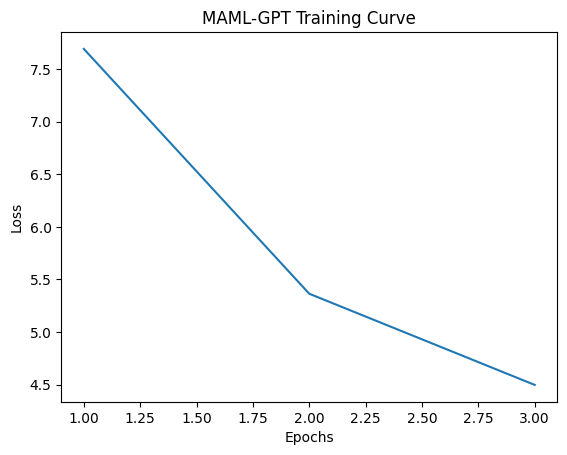

In [7]:
plt.plot(range(1, len(maml_gpt.meta_losses) + 1), maml_gpt.meta_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('MAML-GPT Training Curve')
plt.show()

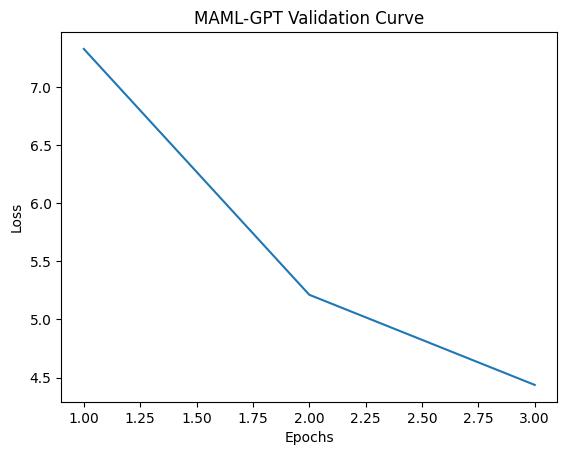

In [8]:
plt.plot(range(1, len(maml_gpt.k_shot_valid_losses) + 1), maml_gpt.k_shot_valid_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('MAML-GPT Validation Curve')
plt.show()